In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import PhillipsPerron
import pprint
from datetime import timedelta



Total samples: 6161
         Date  CLOSE  HIGH  LOW  OPEN
0  1999-03-01   1000   NaN  NaN   NaN
1  1999-03-02   1009   NaN  NaN   NaN
2  1999-03-03   1014   NaN  NaN   NaN
3  1999-03-04   1013   NaN  NaN   NaN
4  1999-03-05   1005   NaN  NaN   NaN


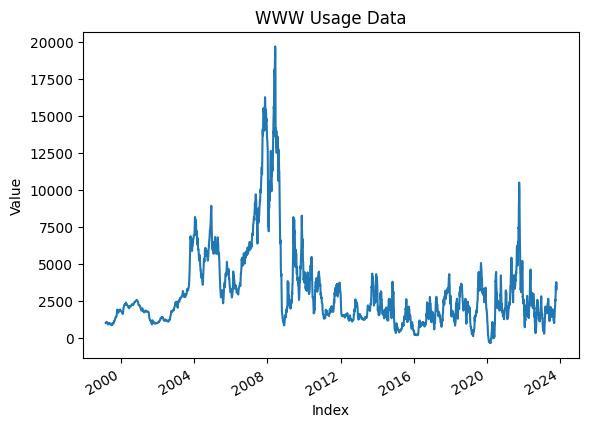

In [62]:
df = pd.read_csv('./data/all_baci.csv')
print(f"Total samples: {len(df)}")
print(df.head())

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)



values = df["CLOSE"]
df['Diff'] = df['CLOSE'].diff()
df["CLOSE"].plot(kind='line', title='WWW Usage Data')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()


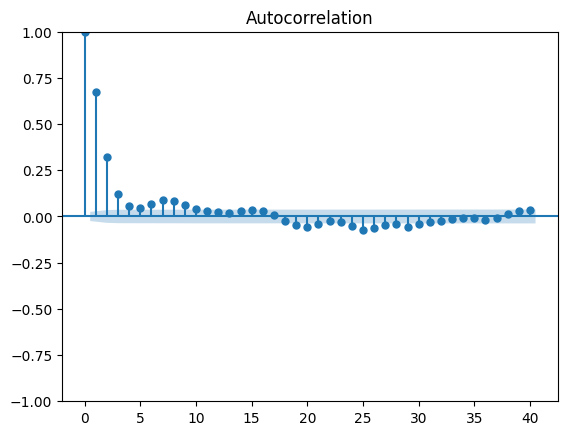

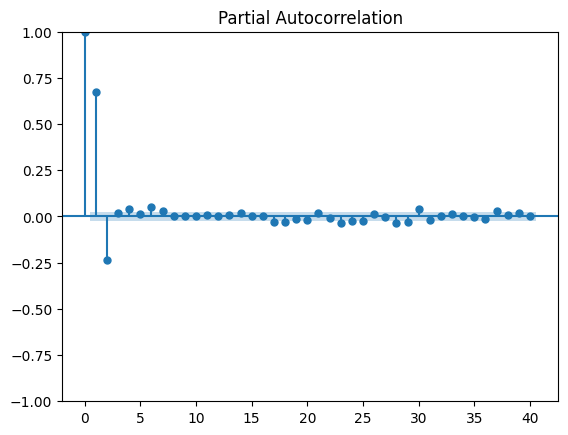

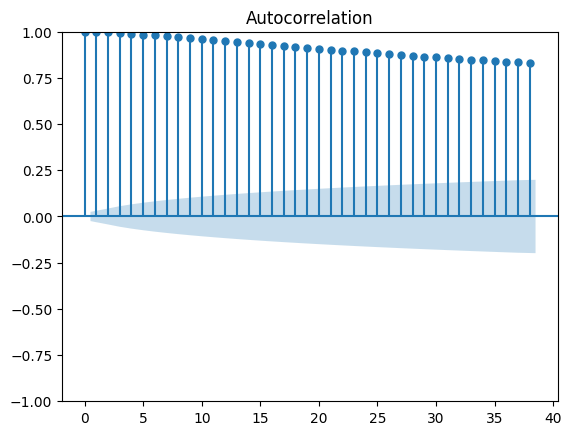

In [59]:

# first difference
plot_acf(df['Diff'].dropna(), lags=40)
plot_pacf(df['Diff'].dropna(), lags=40)

# actual values
plot_acf(values)
plt.show()



In [15]:
!pip install arch

Defaulting to user installation because normal site-packages is not writeable
                                              0.0/922.8 kB ? eta -:--:--
     ----------                             256.0/922.8 kB 7.9 MB/s eta 0:00:01
     ------------------------------------  921.6/922.8 kB 11.7 MB/s eta 0:00:01
     ------------------------------------- 922.8/922.8 kB 11.7 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [60]:
# augmented dickey fuller




result = adfuller(values.dropna())
print('p-value: ', result[1])

result = adfuller(values.diff().dropna())
print('p-value: ', result[1])

result = adfuller(values.diff().diff().dropna())
print('p-value: ', result[1])

# Phillips-Perron

pp_test = PhillipsPerron(df['CLOSE'])
print(pp_test.summary())


p-value:  0.004968049641026875
p-value:  1.3636049694941607e-27
p-value:  0.0
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -3.762
P-value                         0.003
Lags                               34
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\arch\unitroot\unitroot.py:1134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma = resols.bse[0]
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\arch\unitroot\unitroot.py:1142: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rho = resols.params[0]


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters foun

                               SARIMAX Results                                
Dep. Variable:                  CLOSE   No. Observations:                   80
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -241.636
Date:                Thu, 26 Oct 2023   AIC                            497.272
Time:                        13:52:41   BIC                            513.858
Sample:                             0   HQIC                           503.917
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9912      0.192      5.157      0.000       0.614       1.368
ar.L2          0.8012      0.274      2.919      0.004       0.263       1.339
ar.L3         -0.8430      0.131     -6.414      0.0

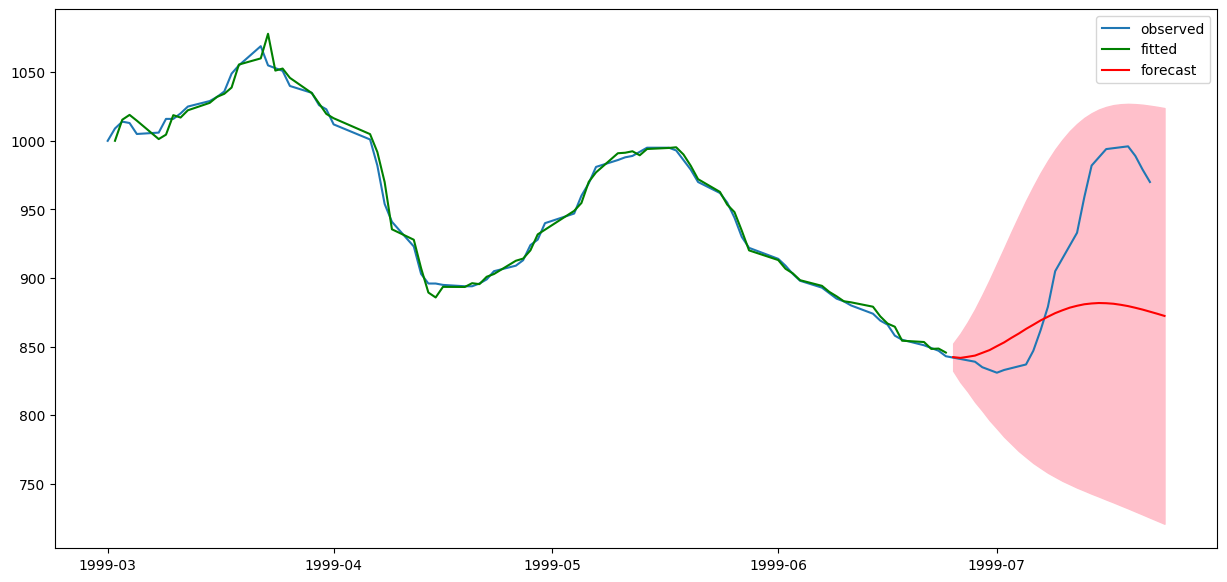

In [63]:

split_df = df.iloc[:100]
# Fit the ARIMA model
train_size = int(0.8 * len(split_df))
train = values.iloc[:train_size]
test = values.iloc[train_size:]
arima_model = ARIMA(train.dropna(), order=(3,1,3))
model = arima_model.fit()
fitted_values = model.fittedvalues[1:]


print(model.summary())
forecast = model.get_forecast(steps=30)  # forecast 30 days into the future
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

# Set the forecast index to start from the day after the end of the training data
forecast_start_date = train.index[-1] + pd.Timedelta(days=1)
forecast_end_date = forecast_start_date + pd.Timedelta(days=30) - pd.Timedelta(days=1)
forecast_index = pd.date_range(forecast_start_date, forecast_end_date)

plt.figure(figsize=(15,7))
plt.plot(split_df['CLOSE'], label='observed')
plt.plot(fitted_values.index, fitted_values.values, color='green', label='fitted')
plt.plot(forecast_index, mean_forecast.values, color='red', label='forecast')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink')
plt.legend()
plt.show()


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


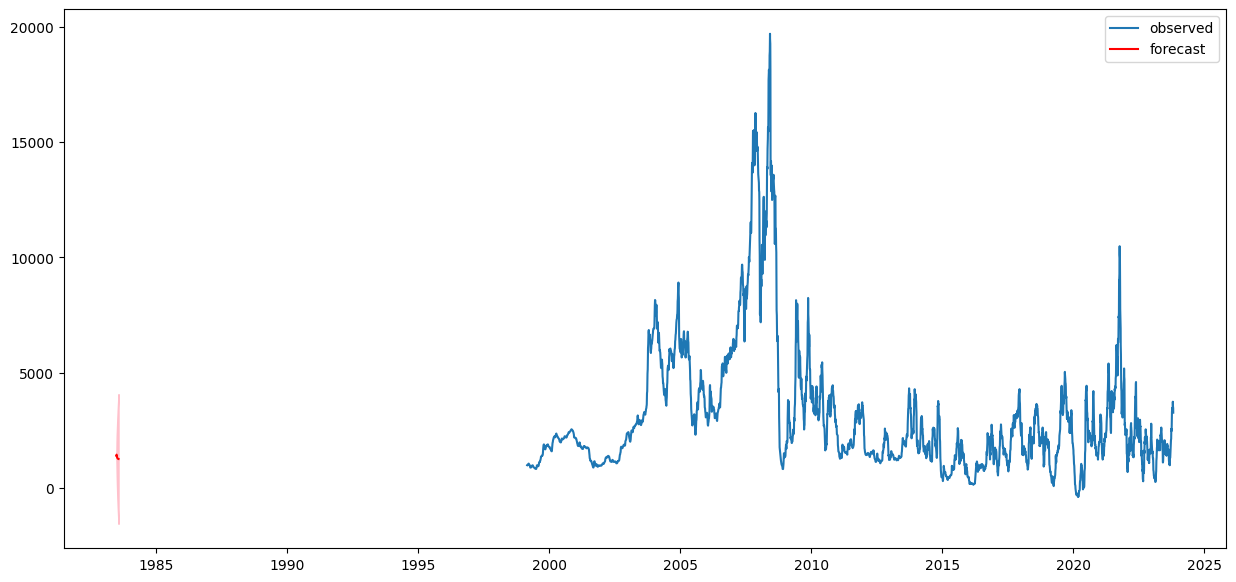

In [31]:
forecast = model.get_forecast(steps=30)  # forecast 30 days into the future
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

plt.figure(figsize=(15,7))
plt.plot(df['CLOSE'], label='observed')
plt.plot(mean_forecast.index, mean_forecast.values, color='red', label='forecast')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink')
plt.legend()
plt.show()

2       12288.552903
3       15001.103790
4       15454.980203
5       15643.218768
6       16876.181939
            ...     
1995    13678.341508
1996    10928.320738
1997    12222.493452
1998    15177.793093
1999    16000.948313
Length: 1998, dtype: float64
2000    17579.976557
2001    17984.642408
2002    18196.290484
2003    18306.986526
2004    18364.882699
2005    18395.163519
2006    18411.000974
2007    18419.284270
2008    18423.616594
2009    18425.882483
2010    18427.067587
2011    18427.687420
2012    18428.011604
2013    18428.181159
2014    18428.269839
2015    18428.316221
2016    18428.340479
2017    18428.353167
2018    18428.359803
2019    18428.363273
Name: predicted_mean, dtype: float64
2       12288.552903
3       15001.103790
4       15454.980203
5       15643.218768
6       16876.181939
            ...     
2015    18428.316221
2016    18428.340479
2017    18428.353167
2018    18428.359803
2019    18428.363273
Length: 2018, dtype: float64


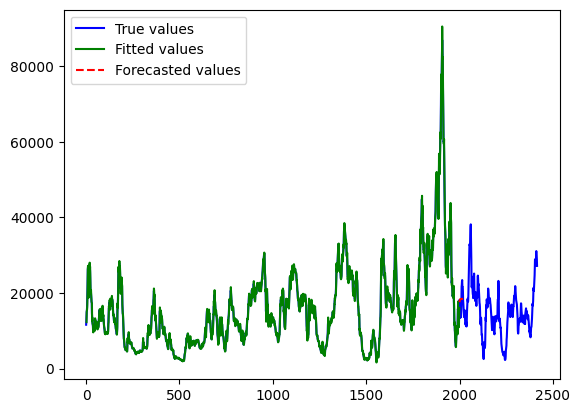

In [19]:

# Create a series of predicted values
y_fitted = model.fittedvalues[2:]
y_pred = model.forecast(20)
print(y_fitted)
print(y_pred)
y = pd.concat([y_fitted, y_pred])
print(y)

# Get the actual values from the dataframe for comparison
y_true_full = values
y_true = values[2000:]

fig, ax = plt.subplots()

# Plot the true values
ax.plot(y_true_full.index, y_true_full, label='True values', color='blue')

# Plot the fitted values (up to 80)
ax.plot(y_fitted.index, y_fitted, label='Fitted values', color='green')

# Plot the forecasted values (from 80 onwards)
ax.plot(y_pred.index, y_pred, label='Forecasted values', color='red', linestyle='--')

# Set the legend
ax.legend()

plt.show()




In [74]:

# Compute error metrics
mape = np.mean(np.abs(y_pred - y_true) / np.abs(y_true))  # Mean absolute percentage error
mae = np.mean(np.abs(y_pred - y_true))                    # Mean absolute error
mpe = np.mean((y_pred - y_true) / y_true)                 # Mean percentage error
rmse = np.sqrt(np.mean((y_pred - y_true)**2))             # Root Mean Squared Error
corr = np.corrcoef(y_pred, y_true)[0, 1]                  # Correlation Coefficient

# MinMax Error
mins = np.minimum(y_pred, y_true)
maxs = np.maximum(y_pred, y_true)
minmax = 1 - np.mean(mins / maxs)

# Print results using pretty print
metrics = {
    'mape': mape,
    'mae': mae,
    'mpe': mpe,
    'rmse': rmse,
    'corr': corr,
    'minmax': minmax
}

pprint.pprint(metrics)







{'corr': 0.9328652877618426,
 'mae': 54.68535812494773,
 'mape': 0.27448845286833146,
 'minmax': 0.27448845286833146,
 'mpe': -0.27448845286833146,
 'rmse': 61.38905719838215}


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2426.086559
dtype: float64
400    2412.668688
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2417.331221
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2415.692637
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2414.674445
dtype: float64
400    2412.058566
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2422.693758
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2428.392151
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2433.15498
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2443.725939
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2448.196031
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2453.984897
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2469.589349
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2478.535845
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2477.665191
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2479.211977
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2482.280021
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2490.800551
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2498.885878
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2513.186732
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2515.190222
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2524.388124
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2523.565935
dtype: float64
400    2550.013097
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2556.173285
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2553.715951
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2560.147386
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2557.433492
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2549.167881
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2546.903458
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2540.560216
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2526.064818
dtype: float64
400    2508.68406
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2507.647464
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2508.706222
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2512.900465
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2497.537599
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2492.419615
dtype: float64
400    2491.021277
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2490.239873
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2488.632172
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2475.190827
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2463.380829
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2457.222458
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2443.760668
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2425.128288
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2395.307082
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2385.154686
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2368.050118
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2320.813345
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2308.452405
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2229.5939
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2197.815055
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2187.028508
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2195.570132
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2196.417845
dtype: float64
400    2202.50086
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2199.641593
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2195.673617
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2201.56146
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2192.204385
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2187.784918
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2182.1742
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2186.150807
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2179.172245
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2165.272146
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2160.132471
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2162.485267
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2166.229573
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2159.745893
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2139.786892
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2123.840381
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2119.414207
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2108.746279
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2070.68663
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2045.162688
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2045.134911
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2018.516233
dtype: float64
400    2003.373337
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    1968.575348
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    1960.898579
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    1935.392795
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    1926.565795
dtype: float64
400    1905.055869
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    1875.125308
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    1855.643644
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    1853.723986
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    1841.670138
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    1826.904834
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    1823.652385
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    1830.421236
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    1825.910646
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    1830.297208
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    1836.508838
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    1839.919278
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    1865.01308
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    1873.214166
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    1879.609033
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    1887.158951
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    1919.918498
dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2426.086559
401    2425.825958
402    2426.157218
403    2427.447012
404    2429.506088
405    2431.804780
406    2433.764008
407    2434.997078
408    2435.423416
409    2435.240538
Name: predicted_mean, dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2448.196031
401    2452.524264
402    2456.089912
403    2458.937418
404    2461.165463
405    2462.839508
406    2464.047556
407    2464.857010
408    2465.341893
409    2465.561793
Name: predicted_mean, dtype: float64
400    2515.190222
401    2519.204993
402    2522.475437
403    2524.894880
404    2526.736069
405    2527.986231
406    2528.823718
407    2529.272978
408    2529.452570
409    2529.396432
Name: predicted_mean, dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2540.560216
401    2536.359907
402    2532.703216
403    2529.388765
404    2526.554332
405    2524.072852
406    2521.994934
407    2520.233533
408    2518.795783
409    2517.618338
Name: predicted_mean, dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2488.632172
401    2487.494061
402    2486.770305
403    2486.226215
404    2485.942636
405    2485.782514
406    2485.777469
407    2485.846625
408    2485.999832
409    2486.189350
Name: predicted_mean, dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2308.452405
401    2291.602091
402    2276.572795
403    2263.868863
404    2253.892971
405    2246.658183
406    2241.743917
407    2238.446092
408    2236.014495
409    2233.865779
Name: predicted_mean, dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2192.204385
401    2190.016601
402    2188.648205
403    2187.716866
404    2187.287962
405    2187.139792
406    2187.278901
407    2187.575053
408    2188.015829
409    2188.524973
Name: predicted_mean, dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2139.786892
401    2130.862417
402    2123.510350
403    2117.290832
404    2112.266532
405    2108.152769
406    2104.918627
407    2102.370325
408    2100.445520
409    2099.008684
Name: predicted_mean, dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    1960.898579
401    1949.976879
402    1940.693362
403    1933.608087
404    1927.840137
405    1923.567181
406    1920.266554
407    1917.954135
408    1916.310241
409    1915.292955
Name: predicted_mean, dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    1830.421236
401    1831.529988
402    1832.733609
403    1834.244914
404    1835.744159
405    1837.332858
406    1838.841725
407    1840.322165
408    1841.688127
409    1842.969201
Name: predicted_mean, dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2426.086559
401    2425.825958
402    2426.157218
403    2427.447012
404    2429.506088
405    2431.804780
406    2433.764008
407    2434.997078
408    2435.423416
409    2435.240538
410    2434.796491
411    2434.432782
412    2434.363283
413    2434.626667
414    2435.114048
415    2435.645040
416    2436.053206
417    2436.246992
418    2436.228855
419    2436.074758
Name: predicted_mean, dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2515.190222
401    2519.204993
402    2522.475437
403    2524.894880
404    2526.736069
405    2527.986231
406    2528.823718
407    2529.272978
408    2529.452570
409    2529.396432
410    2529.183208
411    2528.843925
412    2528.429659
413    2527.964050
414    2527.478883
415    2526.989820
416    2526.515241
417    2526.063953
418    2525.645244
419    2525.262740
Name: predicted_mean, dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2488.632172
401    2487.494061
402    2486.770305
403    2486.226215
404    2485.942636
405    2485.782514
406    2485.777469
407    2485.846625
408    2485.999832
409    2486.189350
410    2486.416584
411    2486.653758
412    2486.899903
413    2487.139432
414    2487.371463
415    2487.587866
416    2487.788590
417    2487.970007
418    2488.132901
419    2488.276270
Name: predicted_mean, dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    2192.204385
401    2190.016601
402    2188.648205
403    2187.716866
404    2187.287962
405    2187.139792
406    2187.278901
407    2187.575053
408    2188.015829
409    2188.524973
410    2189.087916
411    2189.661146
412    2190.233900
413    2190.782791
414    2191.302000
415    2191.780458
416    2192.216532
417    2192.606496
418    2192.951624
419    2193.252329
Name: predicted_mean, dtype: float64


C:\Users\mariumbo\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


400    1960.898579
401    1949.976879
402    1940.693362
403    1933.608087
404    1927.840137
405    1923.567181
406    1920.266554
407    1917.954135
408    1916.310241
409    1915.292955
410    1914.703101
411    1914.487305
412    1914.520998
413    1914.757732
414    1915.120566
415    1915.575316
416    1916.075929
417    1916.600189
418    1917.122069
419    1917.628988
Name: predicted_mean, dtype: float64
{1: [        Date       Values
0 2000-10-03  2426.086559,         Date       Values
0 2000-10-04  2412.668688,         Date       Values
0 2000-10-05  2417.331221,         Date       Values
0 2000-10-06  2415.692637,         Date       Values
0 2000-10-07  2414.674445,         Date       Values
0 2000-10-10  2412.058566,         Date       Values
0 2000-10-11  2422.693758,         Date       Values
0 2000-10-12  2428.392151,         Date      Values
0 2000-10-13  2433.15498,         Date       Values
0 2000-10-14  2443.725939,         Date       Values
0 2000-10-17  2448.19603

ValueError: x and y must have same first dimension, but have shapes (1,) and (100, 1, 2)

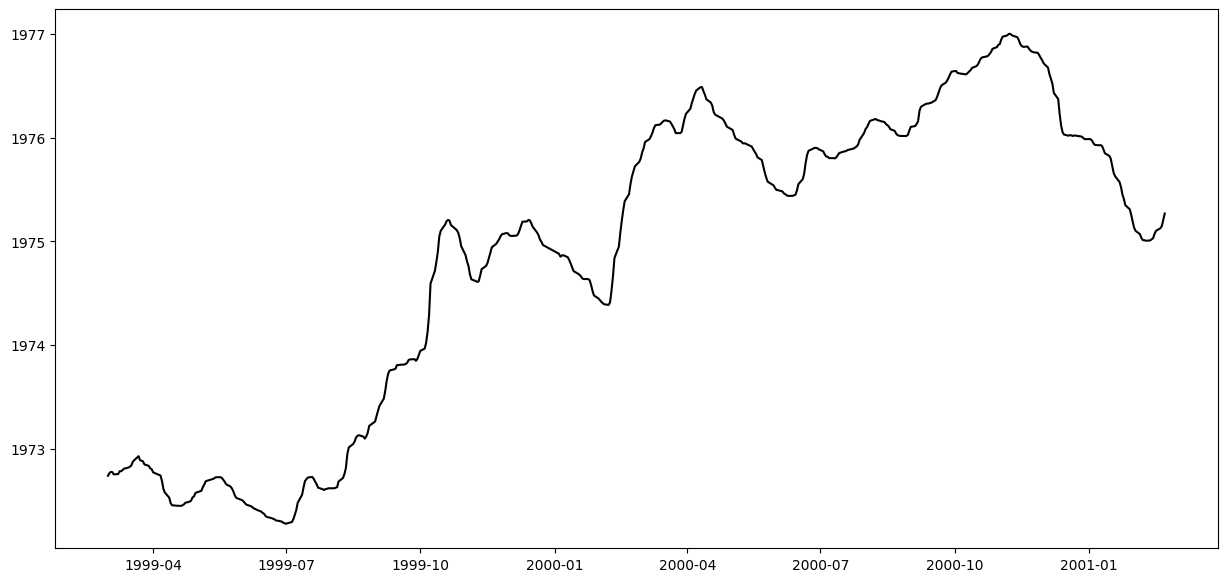

In [64]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter(action="ignore", category=ValueWarning)

sub_df = df.iloc[:500]
values = sub_df["CLOSE"]

# Define the initial training window based on 80% of the data
train_size = int(0.8 * len(sub_df))
train = values.iloc[:train_size]
test = values.iloc[train_size:]

# Define the forecast horizon
forecast_horizons = [1, 10, 20]

forecasts = {}
actuals = {}

for horizon in forecast_horizons:
    current_start = 0
    current_end = train_size
    forecasts[horizon] = []
    actuals[horizon] = []
    
    while current_end + horizon <= len(values):
        current_train = values[current_start:current_end]
        
        model = ARIMA(current_train, order=(3,1,3)) # You may need to adjust the order
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=horizon)
        print(forecast)

        # Set the forecast index to start from the day after the end of the training data
        forecast_start_date = current_train.index[-1] + pd.Timedelta(days=1)
        forecast_end_date = forecast_start_date + pd.Timedelta(days=horizon) - pd.Timedelta(days=1)
        forecast_data = {
            "Date": pd.date_range(forecast_start_date, forecast_end_date),
            "Values": forecast.tolist()
        }
        actual_data = {
            "Date": pd.date_range(forecast_start_date, forecast_end_date),
            "Values": values[current_end:current_end+horizon]
        }
        forecast_df = pd.DataFrame(forecast_data)
        actual_df = pd.DataFrame(actual_data)
        forecasts[horizon].append(forecast_df)
        actuals[horizon].append(actual_df)
        
        current_start += horizon
        current_end += horizon

print(forecasts)

def plot_forecasts(dataframe, forecast_results):
    plt.figure(figsize=(15, 7))
    plt.plot(dataframe.index, dataframe['CLOSE'], label='Historical Data', color='black')
    
    # Colors for different forecasts
    colors = ['red', 'blue', 'green']
    
    # Loop through the forecast results and plot
    for idx, (forecast_horizon, forecasts) in enumerate(forecast_results.items()):
        forecast_dates = [dataframe.index[-1] + timedelta(days=i) for i in range(1, forecast_horizon + 1)]
        forecast_dates = forecast_dates[:len(forecasts)]  # Ensure lengths match
        plt.plot(forecast_dates, forecasts, label=f'{forecast_horizon}-day forecast', color=colors[idx % len(colors)])
        
    plt.title('ARIMA Forecast for Baltic Capesize Index')
    plt.xlabel('Date')
    plt.ylabel('Index Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# You can then call the function like this:
plot_forecasts(sub_df, forecasts)